# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler


import pandas as pd
import numpy as np
import re, time
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# set display options
pd.set_option('display.max_columns', None)

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Udacity-Sparkify-Capstone").getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '41959'),
 ('spark.app.name', 'Udacity-Sparkify-Capstone'),
 ('spark.app.id', 'local-1663102883121'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'c6ae829c258e'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
dataset_df = spark.read.json("./mini_sparkify_event_data.json")

In [6]:
dataset_df.show(5, truncate = False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logg

In [7]:
dataset_df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
dataset_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Possible candidate columns for model training

- userId
- gender
- itemInSession
- length
- level
- location
- page
- registration
- artist
- song
- userAgent


Check for isnull for each of these columns to discard empty rows or impute depending on findings

The following at a first glance do not seem useful to predict churn.
- auth (being logged in or not)
- firstname (user's first name)
- lastname (user's last name)


In [9]:
dataset_df.filter(  isnull(dataset_df["userId"]) | 
                    isnull(dataset_df["gender"]) | 
                    isnull(dataset_df["itemInSession"]) | 
                    isnull(dataset_df["length"]) | 
                    isnull(dataset_df["level"]) | 
                    isnull(dataset_df["location"]) | 
                    isnull(dataset_df["page"]) | 
                    isnull(dataset_df["registration"]) |
                    isnull(dataset_df["artist"]) | 
                    isnull(dataset_df["song"]) | 
                    isnull(dataset_df["userAgent"]) 
                 ).count()

58392

In [10]:
dataset_df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [11]:
dataset_df.count()

286500

In [12]:
# get basic statistics for artist
dataset_df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [13]:
dataset_df.groupby("page").count().show(truncate = False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |14457 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |924   |
|Submit Registration      |5     |
|Settings                 |1514  |
|Login                    |3241  |
|Register                 |18    |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1726  |
|Upgrade                  |499   |
+-------------------------+------+
only showing top 20 rows



In [14]:
# dataset_df.groupby(["userId"]).sum().show(100, truncate=False)

# Clean the data

In [15]:
dataset_df.filter((dataset_df["userId"] == None) | (dataset_df["userId"] == "")).count()

8346

In [16]:
dataset_df.filter(dataset_df.gender.isNotNull()).count()

278154

In [17]:
cleaned_df = dataset_df.filter( dataset_df.userId.isNotNull() & 
                                dataset_df.gender.isNotNull() &
                                dataset_df.itemInSession.isNotNull() &
                                dataset_df.level.isNotNull() &
                                dataset_df.location.isNotNull() &
                                dataset_df.page.isNotNull() &
                                dataset_df.registration.isNotNull() &
                                dataset_df.userAgent.isNotNull() 
                )
cleaned_df.count()

278154

In [18]:
interesting_churn_find_df = dataset_df.filter( dataset_df.userId.isNotNull() & 
                                dataset_df.gender.isNotNull() &
                                dataset_df.itemInSession.isNotNull() &
                                dataset_df.level.isNotNull() &
                                dataset_df.location.isNotNull() &
                                dataset_df.page.isNotNull() &
                                dataset_df.registration.isNotNull() &
                                dataset_df.userAgent.isNotNull() &
                                dataset_df.length.isNotNull() & 
                                dataset_df.artist.isNotNull() &
                                dataset_df.song.isNotNull() 
                )
interesting_churn_find_df.count()

228108

In [19]:
cleaned_df.filter((dataset_df["userId"] == None) | (dataset_df["userId"] == "")).count()

0

In [20]:
cleaned_df.groupby("userId").count().show(truncate = False)

+------+-----+
|userId|count|
+------+-----+
|100010|381  |
|200002|474  |
|125   |11   |
|51    |2464 |
|124   |4825 |
|7     |201  |
|54    |3437 |
|15    |2278 |
|155   |1002 |
|132   |2304 |
|154   |118  |
|100014|310  |
|101   |2149 |
|11    |848  |
|138   |2469 |
|300017|4428 |
|29    |3603 |
|69    |1342 |
|100021|319  |
|42    |4257 |
+------+-----+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [21]:
create_churn_label = udf(lambda page: 1.0 if page == "Cancellation Confirmation" else 0.0, FloatType())

In [22]:
cleaned_df = cleaned_df.withColumn("churn", create_churn_label(cleaned_df["page"]))

In [23]:
interesting_churn_find_df = interesting_churn_find_df.withColumn("churn", create_churn_label(interesting_churn_find_df["page"]))

In [24]:
dataset_df = dataset_df.withColumn("churn", create_churn_label(interesting_churn_find_df["page"]))

In [25]:
cleaned_df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0.0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', churn=0.0)]

In [26]:
churned_count_df = cleaned_df.select(["userId", "churn"]).dropDuplicates().groupby("churn").count()
churned_count_df.show(truncate = False)

+-----+-----+
|churn|count|
+-----+-----+
|1.0  |52   |
|0.0  |225  |
+-----+-----+



In [27]:
interesting_churn_find_df.select(["userId", "churn"]).dropDuplicates().groupby("churn").count().show(truncate = False)

+-----+-----+
|churn|count|
+-----+-----+
|0.0  |225  |
+-----+-----+



In [28]:
# looks like the churn record has length, artist, song, churn as null
cleaned_df.select(["userId", "length", "artist", "song", "churn"]).filter(cleaned_df.churn == 1).show(truncate = False)

+------+------+------+----+-----+
|userId|length|artist|song|churn|
+------+------+------+----+-----+
|18    |null  |null  |null|1.0  |
|32    |null  |null  |null|1.0  |
|125   |null  |null  |null|1.0  |
|105   |null  |null  |null|1.0  |
|17    |null  |null  |null|1.0  |
|143   |null  |null  |null|1.0  |
|101   |null  |null  |null|1.0  |
|129   |null  |null  |null|1.0  |
|121   |null  |null  |null|1.0  |
|51    |null  |null  |null|1.0  |
|87    |null  |null  |null|1.0  |
|122   |null  |null  |null|1.0  |
|12    |null  |null  |null|1.0  |
|58    |null  |null  |null|1.0  |
|73    |null  |null  |null|1.0  |
|3     |null  |null  |null|1.0  |
|106   |null  |null  |null|1.0  |
|103   |null  |null  |null|1.0  |
|28    |null  |null  |null|1.0  |
|54    |null  |null  |null|1.0  |
+------+------+------+----+-----+
only showing top 20 rows



In [29]:
cleaned_df.filter(cleaned_df.churn == 1).show(2, truncate = False)

+------+---------+---------+------+-------------+--------+------+-----+---------------------------+------+-------------------------+-------------+---------+----+------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------+------+-----+
|artist|auth     |firstName|gender|itemInSession|lastName|length|level|location                   |method|page                     |registration |sessionId|song|status|ts           |userAgent                                                                                                                                  |userId|churn|
+------+---------+---------+------+-------------+--------+------+-----+---------------------------+------+-------------------------+-------------+---------+----+------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------+------

## Churn Distribution Plot

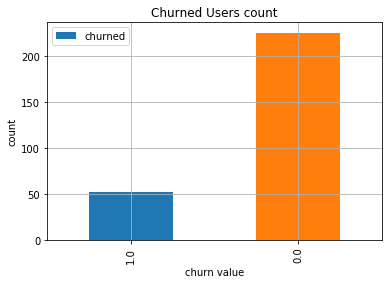

In [30]:

plt.figure(figsize = [6,4])
churned_count_df.toPandas().plot(kind="bar", x="churn", y="count", title="Churned Users count")
plt.xlabel("churn value")
plt.ylabel("count")
plt.grid(True)
plt.legend(["churned", "not churned"], loc ="upper left")
plt.show()

This is a clear case of imbalanced dataset and appropriate ML model selection and metrics are required to deal with this situation. TODO add more details

## Gender impact on Churning

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|  1.0|   20|
|     F|  0.0|  104|
|     M|  1.0|   32|
|     M|  0.0|  121|
+------+-----+-----+



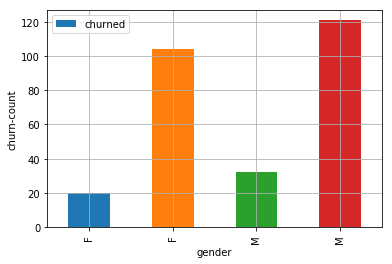

In [31]:
num_gender_df = cleaned_df.select([ "gender","userId", "churn"]).dropDuplicates().groupby(["gender","churn"]).count()
num_gender_df.show()
num_gender_df.toPandas().plot(kind="bar", x="gender", y="count")
plt.xlabel("gender")
plt.ylabel("churn-count")
plt.grid(True)
plt.legend(["churned", "not-churned"], loc ="upper left")
plt.show()

#### Observation from Gender vs Churn

The graph shows males(61.5%) tend to churn more than females(38.5%).

### Level Impact vs Churn 

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|  0.0|  165|
| free|  0.0|  195|
| free|  1.0|   21|
| paid|  1.0|   31|
+-----+-----+-----+



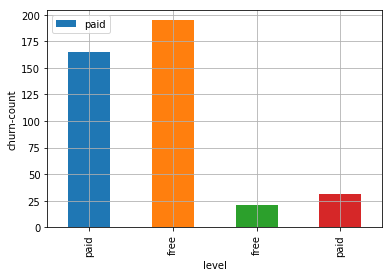

In [32]:
num_level_df = cleaned_df.select([ "level","userId", "churn"]).dropDuplicates().groupby(["level","churn"]).count()
num_level_df.show()
num_level_df.toPandas().plot(kind="bar", x="level", y="count")
plt.xlabel("level")
plt.ylabel("churn-count")
plt.grid(True)
plt.legend(["paid", "free"], loc ="upper left")
#plt.show()

#### Observation from Level/Tier vs Churn

Graph shows paid tier users tend to churn more(59.6%) than free tier users(40.4%)

### Browser/UserAgent Impact on Churn 

In [33]:
num_useragent_df = cleaned_df.filter(cleaned_df["churn"] == 1).select([ "userAgent","userId", "churn"]).dropDuplicates().groupby(["userAgent","churn"]).count()
num_useragent_df.show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------+-----+-----+
|userAgent                                                                                                                                  |churn|count|
+-------------------------------------------------------------------------------------------------------------------------------------------+-----+-----+
|"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                |1.0  |1    |
|Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                   |1.0  |1    |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |1.0  |1    |
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko)

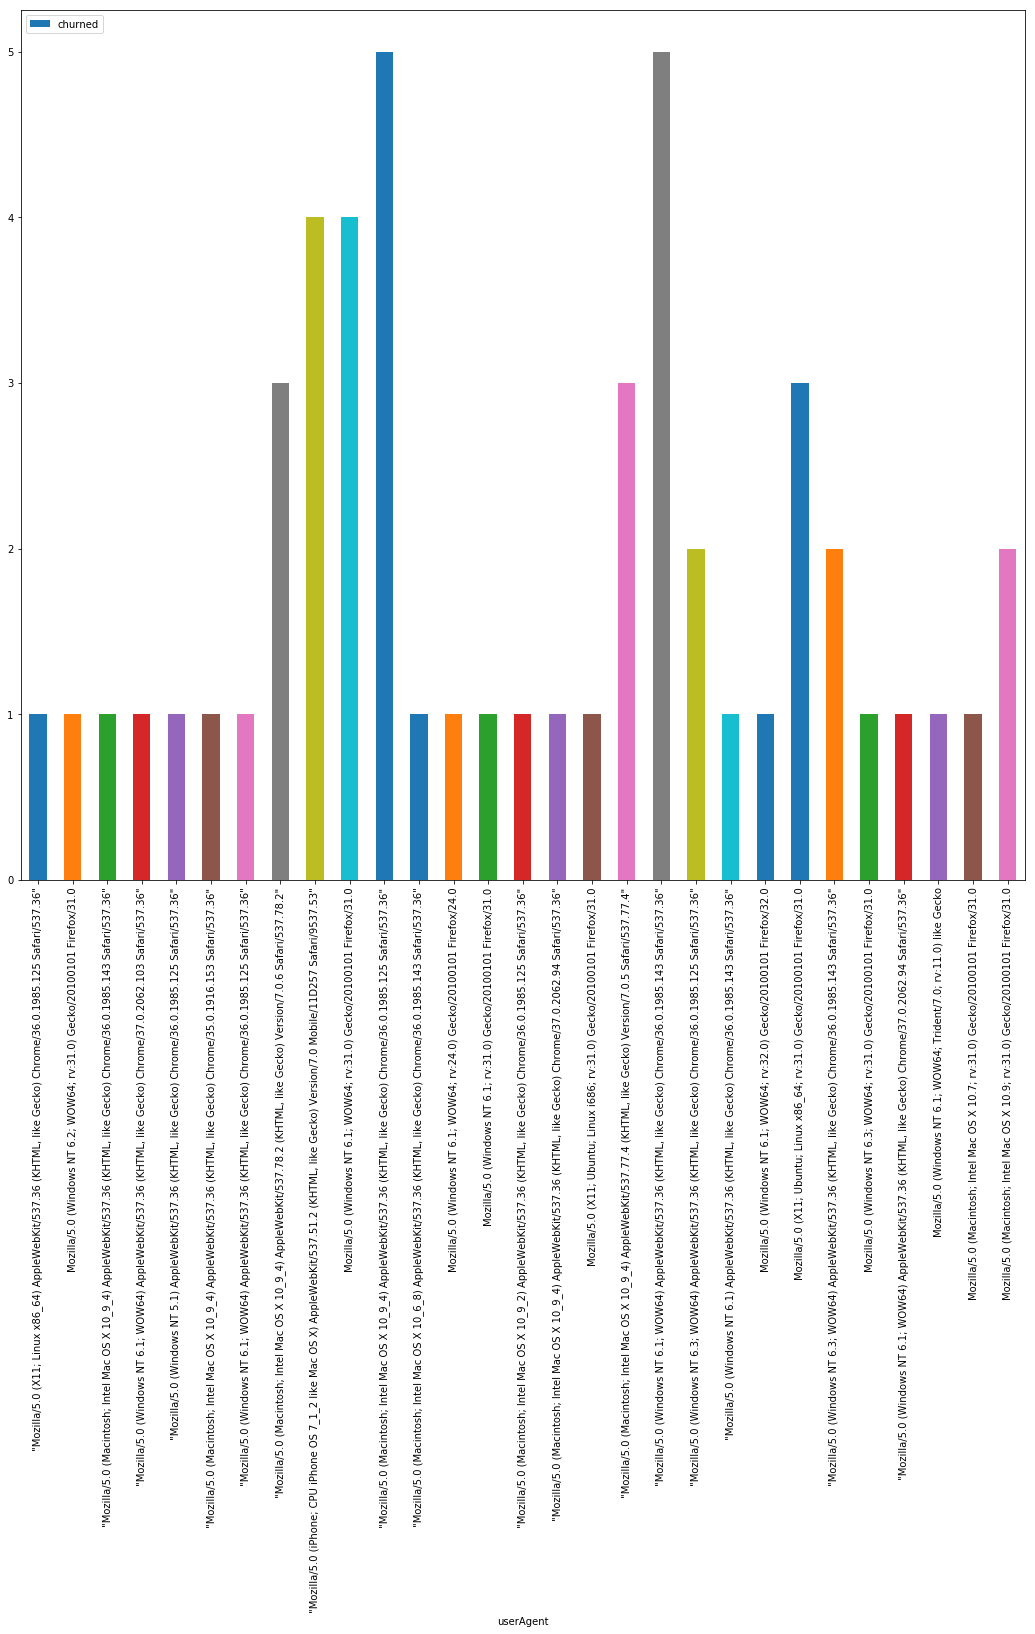

In [34]:
num_useragent_df.toPandas().plot(kind="bar", x="userAgent", y="count", figsize = [18,16], legend=True)
plt.legend(["churned", "not-churned"], loc ="upper left")


#### Observations from useragent

There is no overwhelming or significant correlation of user-agent to subscription cancellation. 
(Mac and Windows Safari browser each have 5 cancellations in the highest values)
Discarding this feature for model prediction.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Useful features for model building

##### Categorical:

- gender
- level


###### Numerical:

- number of unique songs played per userId
- number of total songs played per userId
- number of unique artists per userId
- number of Ads action per userId
- number of thumb down action per userId
- number of thumbs up action per userId
- number of friends added per userId
- number of days after initial registration per userId

#### create feature : gender

In [35]:
set_gender_value = udf(lambda x: 1.0 if x == 'M' else 0.0, FloatType())

In [36]:
ftr_gender  = cleaned_df.withColumn("gender_value", set_gender_value("gender")).select(["userId","gender_value"]).dropDuplicates(["userId","gender_value"])
ftr_gender.show(truncate=False)

+------+------------+
|userId|gender_value|
+------+------------+
|73    |0.0         |
|19    |0.0         |
|123   |1.0         |
|200007|0.0         |
|6     |1.0         |
|67    |1.0         |
|50    |0.0         |
|8     |0.0         |
|300006|1.0         |
|13    |0.0         |
|29    |1.0         |
|7     |1.0         |
|42    |0.0         |
|91    |1.0         |
|200015|1.0         |
|300019|1.0         |
|94    |0.0         |
|86    |1.0         |
|300003|1.0         |
|100011|1.0         |
+------+------------+
only showing top 20 rows



#### create feature : last known level (latest_level)  - free or paid

In [37]:
set_level_value = udf(lambda x: 1.0 if x == 'paid' else 0.0, FloatType())

In [38]:
ftr_level = cleaned_df.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('latest_level')).drop('level')
ftr_level = ftr_level.withColumn("level_value", set_level_value("latest_level")).drop('latest_level')
ftr_level.show(truncate=False)

+------+-----------+
|userId|level_value|
+------+-----------+
|100010|0.0        |
|200002|1.0        |
|125   |0.0        |
|124   |1.0        |
|51    |1.0        |
|7     |0.0        |
|15    |1.0        |
|54    |1.0        |
|155   |1.0        |
|100014|1.0        |
|132   |1.0        |
|154   |0.0        |
|101   |1.0        |
|11    |1.0        |
|138   |1.0        |
|300017|1.0        |
|100021|0.0        |
|29    |1.0        |
|69    |1.0        |
|112   |0.0        |
+------+-----------+
only showing top 20 rows



#### create feature : number of unique songs played per userId

In [39]:
ftr_num_unique_songs = cleaned_df.filter(cleaned_df["page"] == "NextSong").select(["userId","song"]).dropDuplicates(["userId","song"]).groupby(["userId"]).count()
ftr_num_unique_songs = ftr_num_unique_songs.selectExpr("userId as userId", "count as num_unique_songs")
ftr_num_unique_songs.show(truncate=False)

+------+----------------+
|userId|num_unique_songs|
+------+----------------+
|100010|269             |
|200002|378             |
|125   |8               |
|51    |1854            |
|124   |3339            |
|7     |148             |
|15    |1707            |
|54    |2414            |
|155   |759             |
|132   |1718            |
|100014|248             |
|154   |83              |
|101   |1608            |
|11    |616             |
|138   |1791            |
|300017|3013            |
|29    |2562            |
|69    |1036            |
|100021|226             |
|112   |211             |
+------+----------------+
only showing top 20 rows



#### create feature : number of total songs played per userId

In [40]:
ftr_num_total_songs = cleaned_df.filter(cleaned_df["page"] == "NextSong").select(["userId","song"]).groupby(["userId"]).count()
ftr_num_total_songs = ftr_num_total_songs.selectExpr("userId as userId", "count as num_total_songs")
ftr_num_total_songs.show(truncate=False)

+------+---------------+
|userId|num_total_songs|
+------+---------------+
|100010|275            |
|200002|387            |
|125   |8              |
|51    |2111           |
|124   |4079           |
|7     |150            |
|54    |2841           |
|15    |1914           |
|155   |820            |
|132   |1928           |
|154   |84             |
|100014|257            |
|101   |1797           |
|11    |647            |
|138   |2070           |
|300017|3632           |
|29    |3028           |
|69    |1125           |
|100021|230            |
|42    |3573           |
+------+---------------+
only showing top 20 rows



#### number of unique artists per userId

In [41]:
ftr_num_unique_artists = cleaned_df.filter(cleaned_df["page"] == "NextSong").select(["userId","artist"]).dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
ftr_num_unique_artists = ftr_num_unique_artists.selectExpr("userId as userId", "count as num_unique_artists")
ftr_num_unique_artists.show(truncate=False)

+------+------------------+
|userId|num_unique_artists|
+------+------------------+
|100010|252               |
|200002|339               |
|125   |8                 |
|51    |1385              |
|124   |2232              |
|7     |142               |
|15    |1302              |
|54    |1744              |
|155   |643               |
|132   |1299              |
|154   |78                |
|100014|233               |
|101   |1241              |
|11    |534               |
|138   |1332              |
|300017|2070              |
|29    |1804              |
|69    |865               |
|100021|207               |
|42    |2073              |
+------+------------------+
only showing top 20 rows



#### create feature : number of Ads action per userId

In [42]:
roll_advert_event = udf(lambda x: 1.0 if x == "Roll Advert" else 0.0, FloatType())

In [43]:
ftr_num_ads = cleaned_df.withColumn("roll_advert_count", roll_advert_event("page"))
ftr_num_ads.show(5, truncate=False)
                                    

ftr_num_ads = ftr_num_ads.filter(ftr_num_ads["roll_advert_count"] == 1).select(["userId","roll_advert_count"]).groupby(["userId"]).count()
ftr_num_ads = ftr_num_ads.selectExpr("userId as userId", "count as roll_advert_count")
ftr_num_ads.show(truncate=False)


+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+-----+-----------------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|churn|roll_advert_count|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+----------------------------------------------------------------------------------------------

#### create feature: number of thumb down action per userId

In [44]:
thumbs_down_event = udf(lambda x: 1.0 if x == "Thumbs Down" else 0.0, FloatType())

In [45]:
ftr_num_thumbs_down = cleaned_df.withColumn("num_thumbs_down", thumbs_down_event("page"))
ftr_num_thumbs_down.show(5, truncate=False)
                                    

ftr_num_thumbs_down = ftr_num_thumbs_down.filter(ftr_num_thumbs_down["num_thumbs_down"] == 1).select(["userId","num_thumbs_down"]).groupby(["userId"]).count()
ftr_num_thumbs_down = ftr_num_thumbs_down.selectExpr("userId as userId", "count as num_thumbs_down")
ftr_num_thumbs_down.show(truncate=False)


+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+-----+---------------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|churn|num_thumbs_down|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+--------------------------------------------------------------------------------------------------

#### create feature: number of thumb up action per userId

In [46]:
thumbs_up_event = udf(lambda x: 1.0 if x == "Thumbs Up" else 0.0, FloatType())

In [47]:
ftr_num_thumbs_up = cleaned_df.withColumn("num_thumbs_up", thumbs_up_event("page"))
ftr_num_thumbs_up.show(5, truncate=False)
                                    

ftr_num_thumbs_up = ftr_num_thumbs_up.filter(ftr_num_thumbs_up["num_thumbs_up"] == 1).select(["userId","num_thumbs_up"]).groupby(["userId"]).count()
ftr_num_thumbs_up = ftr_num_thumbs_up.selectExpr("userId as userId", "count as num_thumbs_up")
ftr_num_thumbs_up.show(truncate=False)


+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+-----+-------------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|churn|num_thumbs_up|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+------------------------------------------------------------------------------------------------------

#### create feature: number of friends added per userId

In [48]:
add_friends_event = udf(lambda x: 1.0 if x == "Add Friend" else 0.0, FloatType())

In [49]:
ftr_num_add_friends = cleaned_df.withColumn("num_add_friends", add_friends_event("page"))
ftr_num_add_friends.show(5, truncate=False)
                                    

ftr_num_add_friends = ftr_num_add_friends.filter(ftr_num_add_friends["num_add_friends"] == 1).select(["userId","num_add_friends"]).groupby(["userId"]).count()
ftr_num_add_friends = ftr_num_add_friends.selectExpr("userId as userId", "count as num_add_friends")
ftr_num_add_friends.show(truncate=False)


+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+-----+---------------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|churn|num_add_friends|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+--------------------------------------------------------------------------------------------------

####  create featrure: number of days after initial registration per userId

In [50]:
latest_action_df =  cleaned_df.groupBy('userId').agg(max('ts').alias('latest_action'))
print(latest_action_df.count())
num_days_after_registration_df = latest_action_df.join(cleaned_df, on='userId', how="inner").withColumn('num_days_after_registration', ((col('latest_action')-col('registration'))/86400000).cast(FloatType())).select(["userId","num_days_after_registration"]).dropDuplicates()
print(num_days_after_registration_df.count())
num_days_after_registration_df.show(5, truncate=False)

225
225
+------+---------------------------+
|userId|num_days_after_registration|
+------+---------------------------+
|100010|55.643658                  |
|200002|70.07463                   |
|125   |71.31689                   |
|124   |131.55591                  |
|51    |19.455845                  |
+------+---------------------------+
only showing top 5 rows



#### create label field: churn 

In [51]:
label_churn_df = cleaned_df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count().drop('count')
label_churn_df = label_churn_df.selectExpr("userId as userId", "churn as label")
print(label_churn_df.count())
label_churn_df.show(truncate=False)


277
+------+-----+
|userId|label|
+------+-----+
|73    |0.0  |
|19    |0.0  |
|200007|0.0  |
|50    |0.0  |
|100005|0.0  |
|200002|0.0  |
|30    |0.0  |
|8     |0.0  |
|4     |0.0  |
|106   |1.0  |
|200018|0.0  |
|65    |0.0  |
|13    |0.0  |
|29    |1.0  |
|153   |0.0  |
|42    |0.0  |
|200015|1.0  |
|94    |0.0  |
|62    |0.0  |
|114   |0.0  |
+------+-----+
only showing top 20 rows



In [52]:
features_df = ftr_num_unique_songs \
                .join(ftr_num_total_songs, ["userId"]) \
                .join(ftr_num_unique_artists, ["userId"]) \
                .join(ftr_num_ads, ["userId"]) \
                .join(ftr_num_thumbs_down, ["userId"]) \
                .join(ftr_num_thumbs_up, ["userId"]) \
                .join(ftr_num_add_friends, ["userId"]) \
                .join(num_days_after_registration_df, ["userId"]) \
                .join(ftr_gender, ["userId"]) \
                .join(ftr_level, ["userId"]) \
                .join(label_churn_df, ["userId"]) \
                

print(features_df.count())
features_df.show(truncate=False)




219
+------+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+
|userId|num_unique_songs|num_total_songs|num_unique_artists|roll_advert_count|num_thumbs_down|num_thumbs_up|num_add_friends|num_days_after_registration|gender_value|level_value|label|
+------+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+
|100010|269             |275            |252               |52               |5              |17           |4              |55.643658                  |0.0         |0.0        |0.0  |
|200002|378             |387            |339               |7                |6              |21           |4              |70.07463                   |1.0         |1.0        |0.0  |
|124   |3339            |4079           |2232              |4               

In [53]:
features_df =features_df.drop("userId")
features_df.show(truncate=False)

+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+
|num_unique_songs|num_total_songs|num_unique_artists|roll_advert_count|num_thumbs_down|num_thumbs_up|num_add_friends|num_days_after_registration|gender_value|level_value|label|
+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+
|269             |275            |252               |52               |5              |17           |4              |55.643658                  |0.0         |0.0        |0.0  |
|378             |387            |339               |7                |6              |21           |4              |70.07463                   |1.0         |1.0        |0.0  |
|3339            |4079           |2232              |4                |41             |171          |74            

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### convert features to vectors and then scale them to standard normal before training the model

In [54]:

assembler = VectorAssembler(inputCols = ["num_unique_songs", "num_total_songs", "num_unique_artists", "roll_advert_count", "num_thumbs_down", "num_thumbs_up", "num_add_friends", "num_days_after_registration", "gender_value", "level_value"], outputCol = "vector_features")
features_df = assembler.transform(features_df)
features_df.show(truncate=False)

+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+---------------------------------------------------------------------+
|num_unique_songs|num_total_songs|num_unique_artists|roll_advert_count|num_thumbs_down|num_thumbs_up|num_add_friends|num_days_after_registration|gender_value|level_value|label|vector_features                                                      |
+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+---------------------------------------------------------------------+
|269             |275            |252               |52               |5              |17           |4              |55.643658                  |0.0         |0.0        |0.0  |[269.0,275.0,252.0,52.0,5.0,17.0,4.0,55.64365768432617,0.0,0.0]      |
|378        

In [55]:
scaler = StandardScaler(inputCol="vector_features", outputCol="features", withStd=True)
scaler_model = scaler.fit(features_df)
features_df = scaler_model.transform(features_df)
features_df.show(truncate=False)

+----------------+---------------+------------------+-----------------+---------------+-------------+---------------+---------------------------+------------+-----------+-----+---------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|num_unique_songs|num_total_songs|num_unique_artists|roll_advert_count|num_thumbs_down|num_thumbs_up|num_add_friends|num_days_after_registration|gender_value|level_value|label|vector_features                                                      |features                                                                                                                                                                                          |
+----------------+---------------+------------------+-----------------+---------------+-------------+---------------

In [56]:
print(features_df.count())

219


### Stratify sample the train, valid and test dataset for imbalanced churn prediction

- Train and validation split together form 60% of the dataset (train is 60% and validation is 40%)
- Test forms 40% of the dataset

In [57]:
train_valid_df = features_df.stat.sampleBy("label", fractions={0: 0.6, 1: 0.4}, seed = 41)
print(f"Train and validation data count: {str(train_valid_df.count())}")
train_valid_df.groupby("label").count().show(truncate=False)


Train and validation data count: 124
+-----+-----+
|label|count|
+-----+-----+
|1.0  |18   |
|0.0  |106  |
+-----+-----+



In [68]:
train = train_valid_df.stat.sampleBy("label", fractions={0: 0.6, 1: 0.4}, seed = 41)
print(f"Train data count: {str(train.count())}")
train.groupby("label").count().show(truncate=False)

Train data count: 104
+-----+-----+
|label|count|
+-----+-----+
|1.0  |11   |
|0.0  |93   |
+-----+-----+



In [69]:
valid = train_valid_df.subtract(train)
print(f"Valid data count: {str(valid.count())}")
valid.groupby("label").count().show(truncate=False)

Valid data count: 20
+-----+-----+
|label|count|
+-----+-----+
|1.0  |7    |
|0.0  |13   |
+-----+-----+



In [70]:
test = features_df.subtract(train_valid_df)
print(f"Test data count: {str(test.count())}")
test.groupby("label").count().show(truncate=False)

Test data count: 95
+-----+-----+
|label|count|
+-----+-----+
|1.0  |23   |
|0.0  |72   |
+-----+-----+



#### Model Selection

In [71]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=50)
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', seed=9)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=9)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=9)

In [72]:
models = [lr,dt,rf,gbt]

In [73]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

Use the train and validation data to identify which model performs well amongst the ones which are chosen

In [74]:
%%time
for model in models:
    print(f'Start Training >>>> {type(model)}')
    model = model.fit(train)
    
    print(f'Start Prediction >>>> {type(model)}')
    predictions = model.transform(valid)
    
    print(f'F1 for {type(model)} is: {evaluator.evaluate(predictions, {evaluator.metricName: "f1"})}')
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print(f"{type(model)} Accuracy = {accuracy}")
    print("-------------------------------------------------------------")

Start Training >>>> <class 'pyspark.ml.classification.LogisticRegression'>
Start Prediction >>>> <class 'pyspark.ml.classification.LogisticRegressionModel'>
F1 for <class 'pyspark.ml.classification.LogisticRegressionModel'> is: 0.5121212121212122
<class 'pyspark.ml.classification.LogisticRegressionModel'> Accuracy = 0.65
-------------------------------------------------------------
Start Training >>>> <class 'pyspark.ml.classification.DecisionTreeClassifier'>
Start Prediction >>>> <class 'pyspark.ml.classification.DecisionTreeClassificationModel'>
F1 for <class 'pyspark.ml.classification.DecisionTreeClassificationModel'> is: 0.5121212121212122
<class 'pyspark.ml.classification.DecisionTreeClassificationModel'> Accuracy = 0.65
-------------------------------------------------------------
Start Training >>>> <class 'pyspark.ml.classification.RandomForestClassifier'>
Start Prediction >>>> <class 'pyspark.ml.classification.RandomForestClassificationModel'>
F1 for <class 'pyspark.ml.classif

#### Selected Model Tuning

In [75]:
paramsGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[25, 50]) \
    .addGrid(rf.maxDepth,[5, 10]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramsGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=5)

In [76]:
%%time
cvModel = crossval.fit(train)

CPU times: user 11.5 s, sys: 3.24 s, total: 14.8 s
Wall time: 33min 31s


In [77]:
cvModel.avgMetrics

[0.8324460363484752,
 0.8263854302878693,
 0.8173427518108368,
 0.8112821457502307]

#### Used the tuned-model for final prediction on test data

In [78]:
results = cvModel.transform(test)

In [79]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())
print(accuracy)

0.7368421052631579


In [80]:
print(f'F1 for {type(cvModel)} is: {evaluator.evaluate(results, {evaluator.metricName: "f1"})}')

F1 for <class 'pyspark.ml.tuning.CrossValidatorModel'> is: 0.6430622009569379


In [82]:
print(f'Recall for {type(cvModel)} is: {evaluator.evaluate(results, {evaluator.metricName: "weightedRecall"})}')

Recall for <class 'pyspark.ml.tuning.CrossValidatorModel'> is: 0.7368421052631579


In [83]:
print(f'Precision for {type(cvModel)} is: {evaluator.evaluate(results, {evaluator.metricName: "weightedPrecision"})}')

Precision for <class 'pyspark.ml.tuning.CrossValidatorModel'> is: 0.5704584040747029


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.